<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Axes-level-plot-functions" data-toc-modified-id="Axes-level-plot-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Axes-level plot functions</a></span><ul class="toc-item"><li><span><a href="#Load-data-and-metadata" data-toc-modified-id="Load-data-and-metadata-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load data and metadata</a></span></li><li><span><a href="#Grid-plot" data-toc-modified-id="Grid-plot-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Grid plot</a></span></li><li><span><a href="#Line-plot" data-toc-modified-id="Line-plot-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Line plot</a></span></li><li><span><a href="#Bar-plot-(optionally-with-splines)" data-toc-modified-id="Bar-plot-(optionally-with-splines)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Bar plot (optionally with splines)</a></span></li></ul></li><li><span><a href="#Plotting-multiple-regions-at-once:-create_dmr_plots" data-toc-modified-id="Plotting-multiple-regions-at-once:-create_dmr_plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plotting multiple regions at once: create_dmr_plots</a></span><ul class="toc-item"><li><span><a href="#Load-input-data" data-toc-modified-id="Load-input-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load input data</a></span></li><li><span><a href="#Create-plots" data-toc-modified-id="Create-plots-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create plots</a></span><ul class="toc-item"><li><span><a href="#Details-on-create_region_plots-args" data-toc-modified-id="Details-on-create_region_plots-args-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Details on create_region_plots args</a></span></li></ul></li></ul></li></ul></div>

**This notebook demonstrates the usage of the methlevel region plot functions (methlevels.plot module)**

TODO:
- lineplot for multiple compartments (on multiple axes), with separate legend per compartment
- display create_region_plots results within this notebook


# Setup

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import tempfile
import subprocess

import pandas as pd
import numpy as np
import pyranges as pr
from IPython.display import display

import matplotlib as mpl
from matplotlib.axes import Axes  # for autocompletion in pycharm
from matplotlib.figure import Figure  # for autocompletion in pycharm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import methlevels as ml

In [17]:
paper_context = {
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 8,
    "axes.titleweight": "bold",
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.8,
    "lines.linewidth": 0.8,
    "lines.markersize": 3,
    "patch.linewidth": 0.8,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.minor.width": 0.8,
    "ytick.minor.width": 0.8,
    "xtick.major.size": 4.800_000_000_000_001,
    "ytick.major.size": 4.800_000_000_000_001,
    "xtick.minor.size": 3.2,
    "ytick.minor.size": 3.2,
}
mpl.rcParams.update(paper_context)

linestyles = dict(
    [
        ("solid", ()),
        ("dotted", (1, 5)),
        ("dashed", (5, 5)),
        ("dashdotted", (3, 5, 1, 5)),
        ("dashdotdotted", (3, 5, 1, 5, 1, 5)),
    ]
)

# Axes-level plot functions

## Load data and metadata

The axes level functions need to know the subject order - for ordering within the plot or for ordering of legend entries
Subject to hue level and subject to line style maps can be provided as dictionaries
Here, we create a dataframe with different subject metadata, from which we can easily retrieve dicts later on

In [18]:
subject_order = [
    "hsc",
    "mpp4",
    "mep",
    "gmp",
    "clp",
    "cfu-e",
    "neutros",
    "dc-cd8a",
    "b-cells",
    "t-cells",
]
subject_metadata = pd.DataFrame(
    [
        ["HSPC", "gray", linestyles["solid"]],
        ["HSPC", "gray", linestyles["dashed"]],
        ["Ery", "orange", linestyles["solid"]],
        ["Myeloid", "green", linestyles["solid"]],
        ["Lymphoid", "blue", linestyles["solid"]],
        ["Ery", "orange", linestyles["dashed"]],
        ["Myeloid", "green", linestyles["dashed"]],
        ["Lymphoid", "blue", linestyles["dashed"]],
        ["Lymphoid", "blue", linestyles["dashdotted"]],
        ["Lymphoid", "blue", linestyles["dotted"]],
    ],
    index=subject_order,
    columns=["compartment", "color", "linestyle"],
)
subject_metadata


,compartment,color,linestyle
hsc,HSPC,gray,()
mpp4,HSPC,gray,"(5, 5)"
mep,Ery,orange,()
gmp,Myeloid,green,()
clp,Lymphoid,blue,()
cfu-e,Ery,orange,"(5, 5)"
neutros,Myeloid,green,"(5, 5)"
dc-cd8a,Lymphoid,blue,"(5, 5)"
b-cells,Lymphoid,blue,"(3, 5, 1, 5)"
t-cells,Lymphoid,blue,"(1, 5)"


All axes level functions require tidy beta value dataframes with at least columns
- Chromosome, Start, End
- subject
- beta_value

if subject is Categorical, the subject_order or legend_order arguments are optional

In [19]:
beta_values_tidy = pd.read_csv(
    "/home/stephen/projects/methlevels/doc/data/plots_beta-values-tidy.tsv", sep="\t"
).query("subject in @subject_order")
display(beta_values_tidy.head())
display(beta_values_tidy.dtypes)


,Chromosome,Start,End,subject,beta_value
0,1,3337916,3337918,hsc,0.960000
4,1,3337916,3337918,mpp4,0.876923
8,1,3337916,3337918,mep,0.555556
9,1,3337916,3337918,gmp,0.850000
10,1,3337916,3337918,clp,0.847826


Chromosome      int64
Start           int64
End             int64
subject        object
beta_value    float64
dtype: object

all axes-level plot functions share a common minimal interface, which allows us to define these args as a common kwargs dict

In [20]:
region_properties = pd.Series({"Chromosome": "1", "Start": 3_337_916, "End": 3_338_818})
common_plot_args = dict(
    beta_values=beta_values_tidy,
    region_properties=region_properties,
    title="Description | 1:100-200",
    xticks=[
        beta_values_tidy.iloc[0, 1],
        region_properties["Start"],
        region_properties["End"],
        beta_values_tidy.iloc[-1, 1],
    ],
    xlabel="% Methylation",
    bp_padding=200,
)

## Grid plot

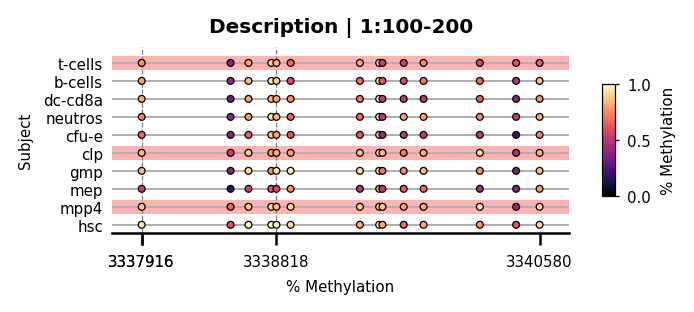

In [21]:
# Coarse figure size estimation
estimated_colorbar_size = 1.5 / 2.54
text_height = mpl.rcParams["xtick.labelsize"] * 1 / 72
axes_width_in = 8 / 2.54

# Create plot
fig, ax = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(
        axes_width_in + estimated_colorbar_size,
        text_height * len(subject_order) + 2 / 2.54,
    ),
    dpi=180,
)
ml.plots.grid_plot(
    ax=ax,
    highlighted_subjects=["mpp4", "clp", "t-cells"],
    cbar_args=dict(shrink=0.6, aspect=20),
    markersize=30,
    fig=fig,
    region_boundaries=True,
    subject_order=subject_order,
    **common_plot_args,
)

## Line plot
- instead of a *subject_order* defining facetting or y-axis ordering, we specify a legend entry order,
  which may be different from the subject order used in grid and bar plots


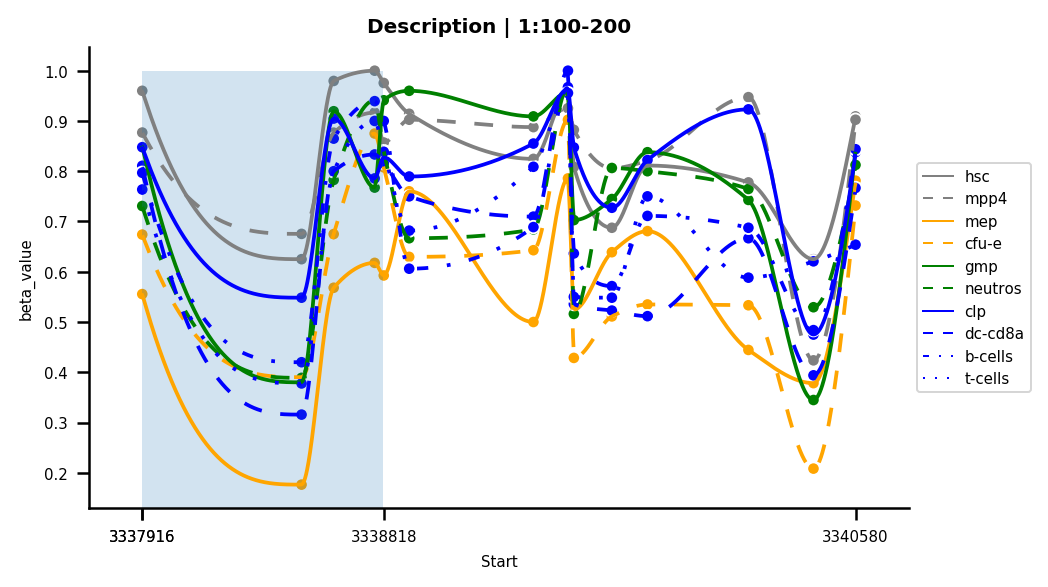

In [22]:

legend_order = [
    "hsc",
    "mpp4",
    "mep",
    "cfu-e",
    "gmp",
    "neutros",
    "clp",
    "dc-cd8a",
    "b-cells",
    "t-cells",
]

# Coarse figure size estimation
estimated_legend_size = 2.5 / 2.54

# Create plot
fig, ax = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(12 / 2.54 + estimated_legend_size, 8 / 2.54),
    dpi=180,
)
# while passing Series to palette or dashes can work (maybe not always?), this may interfere with legend entry ordering. Therefore take care to pass dict instead!
ml.line_plot(
    ax=ax,
    **common_plot_args,
    region_boundaries="box",
    yticks=np.linspace(0, 1, 11),
    palette=subject_metadata["color"].to_dict(),
    dashes=subject_metadata["linestyle"].to_dict(),
    legend_order=legend_order,
    seaborn_lineplot_args=dict(linewidth=1.5),
    # also try:
    # cpg_marks='vlines',
    # cpg_marks_plot_kws=dict(color='red'),
    cpg_marks="points",
    cpg_marks_plot_kws=dict(s=100),
)


## Bar plot (optionally with splines)

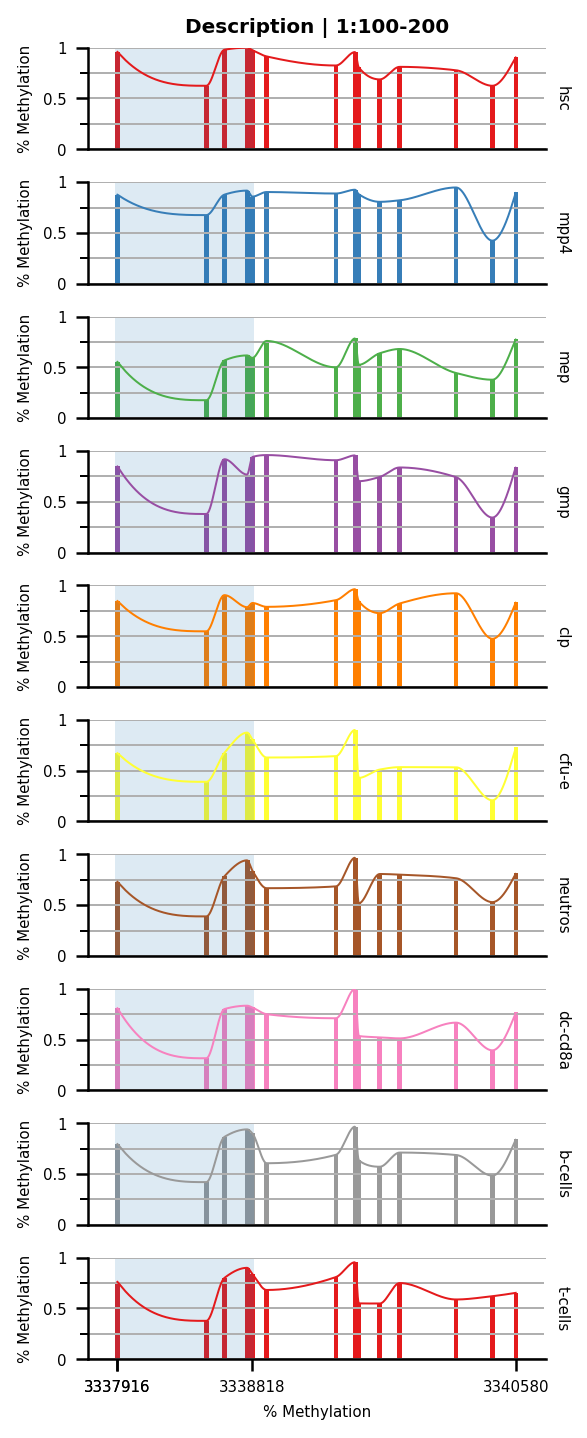

In [23]:

# Create plot
bar_plot_facet_height_in = 2 / 2.54
fig, axes = plt.subplots(
    len(subject_order),
    1,
    constrained_layout=True,
    figsize=(8 / 2.54, bar_plot_facet_height_in * len(subject_order)),
    dpi=180,
)
ml.bar_plot(
    axes=axes,
    show_splines=True,
    palette="Set1",
    dashes=None,
    yticks_major=[0, 0.5, 1],
    yticks_minor=[0.25, 0.75],
    region_boundaries="box",
    **common_plot_args,
    subject_order=subject_order,
)

# Plotting multiple regions at once: create_dmr_plots

This section describe the usage of the create_region_plots function, which
creates visualizations for multiple ROIs, using one or more of the plot types introduced above


## Load input data

The ROI to be plotted are expected to be BED-like coordinates


In [24]:
regions = pd.read_csv(
    "/home/stephen/projects/methlevels/doc/data/plots_dmrs.bed", sep="\t"
).iloc[3:6]
regions

,Chromosome,Start,End
3,1,3646591,3647034
4,1,3708364,3708588
5,1,3756165,3756808


Beta values are given in wide format.
Currently only a scalar columns index of subject names is supported, a MultiIndex with
subject and replicate information could be supported in the future without major effort.
To provide a plotting order for the subject, either the columns index must be categorical,
or the plotting functions must be provided with a subject_order (List[str])


In [25]:
beta_values = pd.read_csv(
    "/home/stephen/projects/methlevels/doc/data/plots_beta-values.tsv", sep="\t"
)[subject_order]
beta_values.head()

,hsc,mpp4,mep,gmp,clp,cfu-e,neutros,dc-cd8a,b-cells,t-cells
0,0.960000,0.876923,0.555556,0.850000,0.847826,0.673913,0.730769,0.810811,0.796875,0.763636
1,0.625000,0.675325,0.176471,0.380000,0.548387,0.390244,0.388889,0.315789,0.420000,0.377778
2,0.979592,0.876712,0.568182,0.919355,0.904762,0.675000,0.782609,0.800000,0.864865,0.800000
3,1.000000,0.916667,0.617647,0.767442,0.785714,0.875000,0.941176,0.833333,0.939394,0.900000
4,0.975610,0.857143,0.592593,0.941176,0.827586,0.807692,0.840000,0.815789,0.900000,0.838710


The CpG index must be aligned with the cpg-rows in beta_values. It must have a element_idx metadata column,
which is simply a running integer index for the CpG positions in beta_values.


In [26]:
cpg_pos = pd.read_csv(
    "/home/stephen/projects/methlevels/doc/data/plots_cpg-pos.bed", sep="\t"
)
cpg_gr = pr.PyRanges(cpg_pos.assign(element_idx=np.arange(len(cpg_pos))))
assert len(cpg_gr) == len(beta_values)
cpg_gr


+--------------+-----------+-----------+---------------+
| Chromosome   | Start     | End       | element_idx   |
| (category)   | (int32)   | (int32)   | (int64)       |
|--------------+-----------+-----------+---------------|
| 1            | 3337916   | 3337918   | 0             |
| 1            | 3338511   | 3338513   | 1             |
| 1            | 3338631   | 3338633   | 2             |
| ...          | ...       | ...       | ...           |
| 1            | 4170152   | 4170154   | 222           |
| 1            | 4170194   | 4170196   | 223           |
| 1            | 4170434   | 4170436   | 224           |
+--------------+-----------+-----------+---------------+
PyRanges object has 225 sequences from 1 chromosomes.

## Create plots

### Details on create_region_plots args

- All plots are placed in *output_dir*, with filename {title}.{suffix}.
- The title is given by the genomic coordinate, eg 1:100-200, and optionally prefixed with the value of
*title_col* for the ROI (retrieved from the **regions** dataframe).
- *show_title* controls whether the title (used for the filename) is also shown in the plots.
- The plot types to be created are controlled by *plot_types*
- The ROIs can be extended prior to plotting using *slack_abs* (absolute flanks in both directions)
- if the ROIs are extended, consider visualizing the region_boundaries. All Axes level functions take a region_boundaries argument which controls this visualizaton (see above)
- to control the different plot types, use the plot specific kws dicts: *grid_kwargs*, *line_kwargs*, *bar_kwargs*




In [27]:
tempdir_o = tempfile.TemporaryDirectory()
ml.create_region_plots(
    beta_values=beta_values,
    cpg_gr=cpg_gr,
    regions=regions,
    output_dir=tempdir_o.name,
    plot_types=["grid", "line", "bar"],
    title_col=None,
    filetypes=["png"],
    slack_abs=500,
    subject_order=subject_order,
    legend_order=legend_order,
    show_title=True,
    grid_kwargs=dict(region_boundaries=True),
    line_kwargs=dict(region_boundaries="box"),
    bar_kwargs=dict(region_boundaries="box"),
)


Saving /tmp/tmpisbv2q56/1_3646591-3647034_kind-grid.png
Saving /tmp/tmpisbv2q56/1_3646591-3647034_kind-line.png
Saving /tmp/tmpisbv2q56/1_3646591-3647034_kind-bar.png
Saving /tmp/tmpisbv2q56/1_3708364-3708588_kind-grid.png
Saving /tmp/tmpisbv2q56/1_3708364-3708588_kind-line.png
Saving /tmp/tmpisbv2q56/1_3708364-3708588_kind-bar.png
Saving /tmp/tmpisbv2q56/1_3756165-3756808_kind-grid.png
Saving /tmp/tmpisbv2q56/1_3756165-3756808_kind-line.png
Saving /tmp/tmpisbv2q56/1_3756165-3756808_kind-bar.png


In [28]:
subprocess.run(["firefox", tempdir_o.name])

CompletedProcess(args=['firefox', '/tmp/tmpisbv2q56'], returncode=0)